<a href="https://colab.research.google.com/github/Arazsh/TensorFlow-in-Practice/blob/master/Transfer_Learning_CNN_cat_VS_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an example project of Transfer Learning in TensorFlow. For the transfer learning, the Inception V3 model is used which has been pre-trained by a dataset of 1.4 million images with 1000 classes from http://www.image-net.org/. The purpose of this code is to develope a network that can detect cats VS dogs. The cats VS dogs dataset can be found at https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip. 


##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#importing the libraries 
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

# A copy of the pre-trained weights for the inception model is available at this link
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

#Keras has the inception model as built-in   
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#instantiating the model with our desired input shape for data. We dont use the built-in weights. We also disable 
#the fully connected layer at the top of the model.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

#Freezing the pre_trained model and preventing it to be trained with the new dataset
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()
#selecting the layer output of the pre-trained model to be used as the input to our desired model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-08-14 05:00:52--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   106MB/s    in 0.8s    

2020-08-14 05:00:53 (106 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                    

In [ ]:
#Adding the desired deep layers to the output of the pre-trained filter bank (convolutional layers) and building the model

#importing the desired optimizer
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification 
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [ ]:
#Downloading the cats_and_dogs dataset to form the train and test sets for the model using ImageDataGenerator

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-08-14 05:01:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.28.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   139MB/s    in 0.5s    

2020-08-14 05:01:39 (139 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 18s - loss: 0.3448 - accuracy: 0.8705 - val_loss: 0.1744 - val_accuracy: 0.9330
Epoch 2/20
100/100 - 17s - loss: 0.2335 - accuracy: 0.9080 - val_loss: 0.1053 - val_accuracy: 0.9610
Epoch 3/20
100/100 - 17s - loss: 0.2054 - accuracy: 0.9175 - val_loss: 0.0979 - val_accuracy: 0.9670
Epoch 4/20
100/100 - 17s - loss: 0.1843 - accuracy: 0.9395 - val_loss: 0.1102 - val_accuracy: 0.9680
Epoch 5/20
100/100 - 17s - loss: 0.1703 - accuracy: 0.9405 - val_loss: 0.1326 - val_accuracy: 0.9580
Epoch 6/20
100/100 - 17s - loss: 0.1832 - accuracy: 0.9375 - val_loss: 0.1085 - val_accuracy: 0.9640
Epoch 7/20
100/100 - 17s - loss: 0.1837 - accuracy: 0.9285 - val_loss: 0.1398 - val_accuracy: 0.9570
Epoch 8/20
100/100 - 17s - loss: 0.1973 - accuracy: 0.9350 - val_loss: 0.0993 - val_accuracy: 0.9660
Epoch 9/20
100/100 - 17s - loss: 0.1546 - accuracy: 0.9460 - val_loss: 0.1713 - val_accuracy: 0.9540
Epoch 10/20
100/100 - 17s - loss: 0.1513 - accuracy: 0.9455 - val_loss: 0.1504 - val_accura

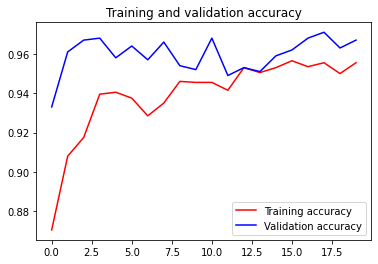

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting the loss and accuracy VS epochs 

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#Testing the trained model on images outside the cats_and_dogs dataset
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  y=image.img_to_array(img)
  y=np.expand_dims(y, axis=0)
  images = np.vstack([y])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")
 

Saving cat1.jpeg to cat1.jpeg
Saving cat2.jpeg to cat2.jpeg
Saving cat3.png to cat3.png
Saving cat4.jpeg to cat4.jpeg
Saving cat5.jpeg to cat5.jpeg
Saving cat6.jpeg to cat6.jpeg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.png to dog3.png
Saving dog4.jpeg to dog4.jpeg
Saving dog5.jpeg to dog5.jpeg
Saving dog6.jpeg to dog6.jpeg
[0.]
cat1.jpeg is a cat
[0.]
cat2.jpeg is a cat
[0.]
cat3.png is a cat
[0.]
cat4.jpeg is a cat
[0.]
cat5.jpeg is a cat
[0.]
cat6.jpeg is a cat
[0.]
dog1.jpg is a cat
[1.]
dog2.jpg is a dog
[1.]
dog3.png is a dog
[0.9999957]
dog4.jpeg is a dog
[3.0507156e-36]
dog5.jpeg is a dog
[1.]
dog6.jpeg is a dog
